# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## MNIST Dataset


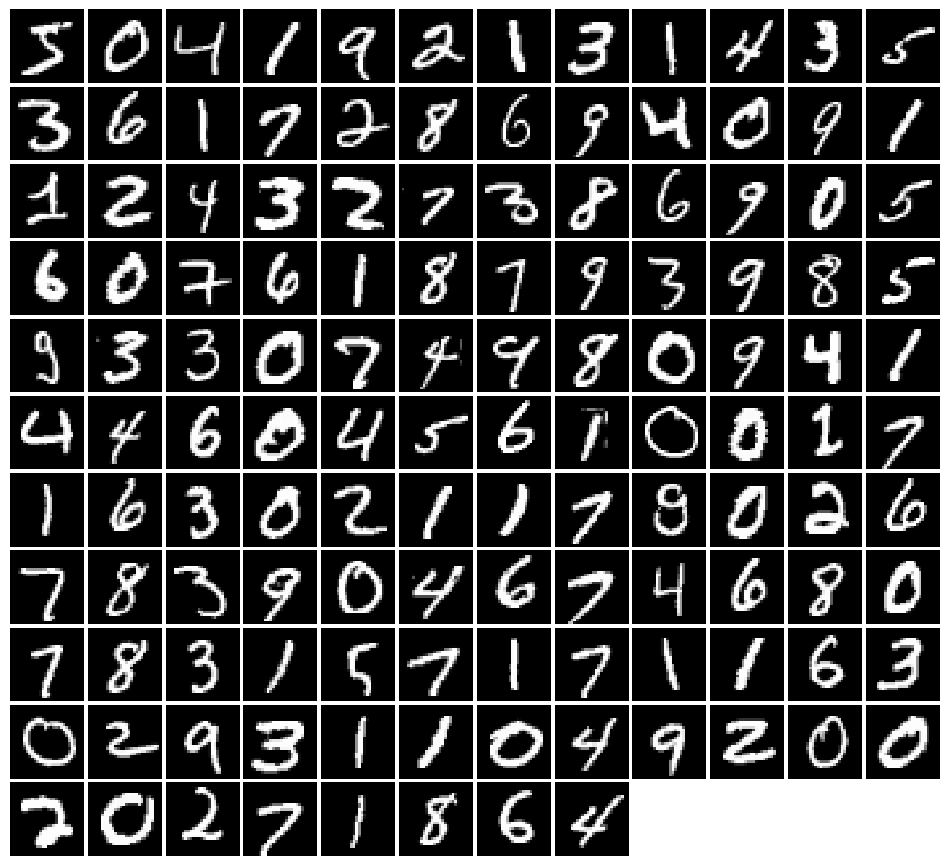

In [6]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = next(loader_train.__iter__())[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [30]:
class Flatten(nn.Module):
    def forward(self, x):
        shp = x.size() # read in N, C, H, W
        return x.view(shp[0], -1)  # "flatten" the C * H * W values into a single vector per image


In [31]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential(
                                Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [32]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        Flatten(),
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 0.6844, G:0.7207


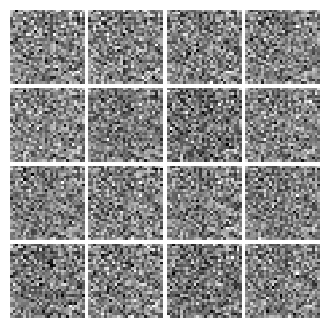


Iter: 250, D: 0.3141, G:1.747


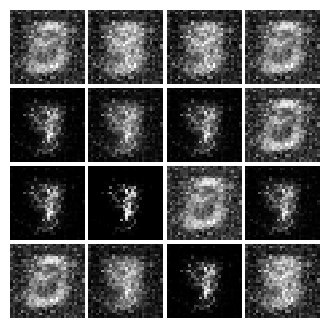


EPOCH:  2
Iter: 500, D: 0.4929, G:1.189


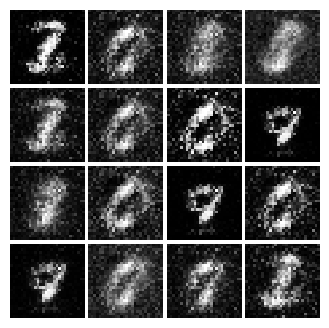


Iter: 750, D: 0.5244, G:2.19


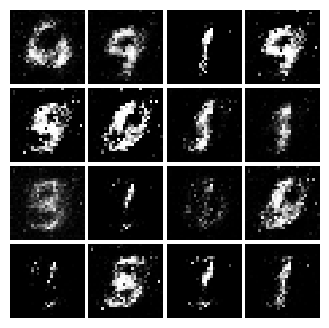


EPOCH:  3
Iter: 1000, D: 0.583, G:1.475


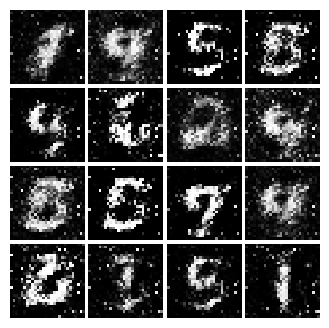


Iter: 1250, D: 0.4733, G:1.34


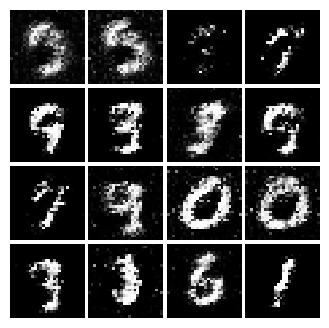


EPOCH:  4
Iter: 1500, D: 0.5484, G:1.071


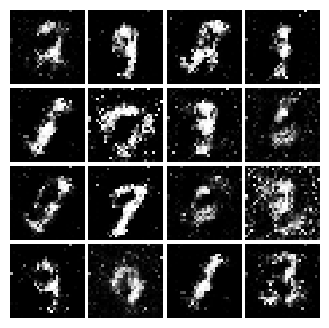


Iter: 1750, D: 0.5775, G:1.086


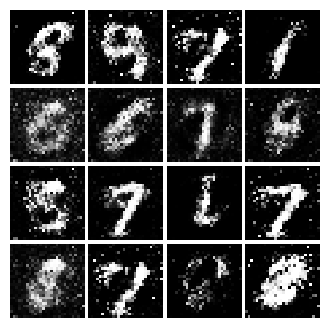


EPOCH:  5
Iter: 2000, D: 0.688, G:0.9522


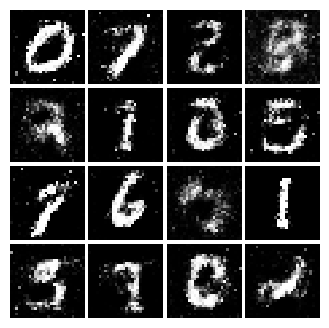


Iter: 2250, D: 0.6572, G:0.9535


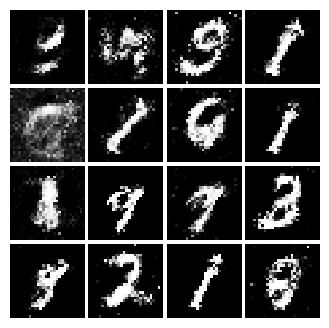


EPOCH:  6
Iter: 2500, D: 0.6282, G:0.9312


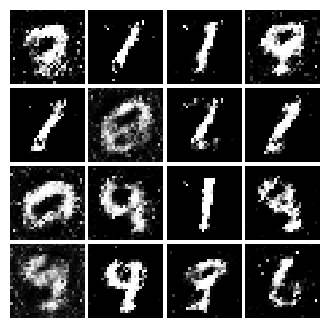


Iter: 2750, D: 0.6608, G:0.9211


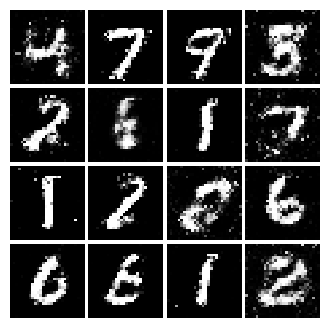


EPOCH:  7
Iter: 3000, D: 0.6295, G:0.9311


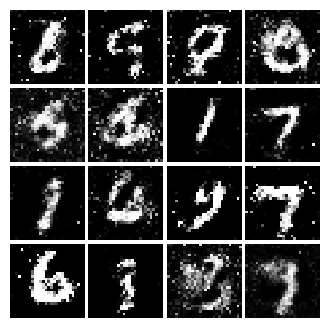


Iter: 3250, D: 0.5979, G:0.9816


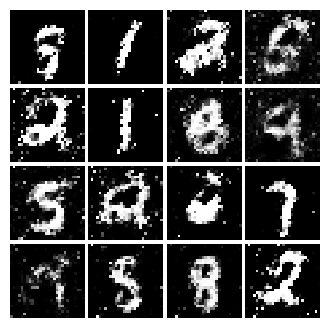


EPOCH:  8
Iter: 3500, D: 0.6548, G:0.8265


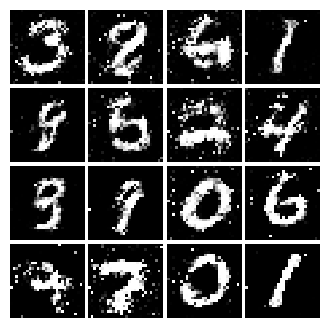


EPOCH:  9
Iter: 3750, D: 0.62, G:0.8049


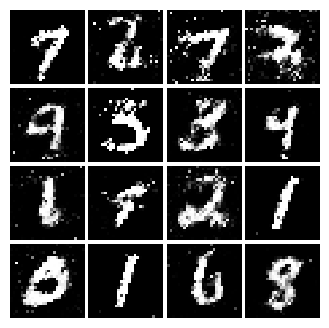


Iter: 4000, D: 0.6409, G:0.7803


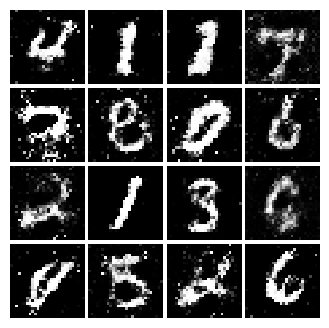


EPOCH:  10
Iter: 4250, D: 0.6205, G:0.8566


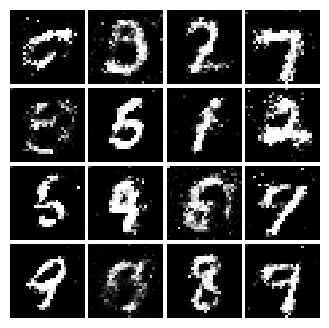


Iter: 4500, D: 0.6273, G:0.7678


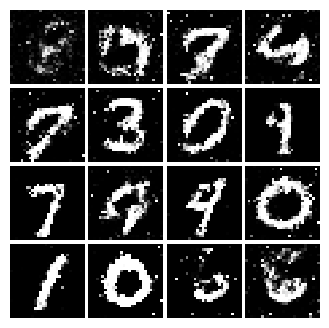

In [33]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.5471, G:0.5552


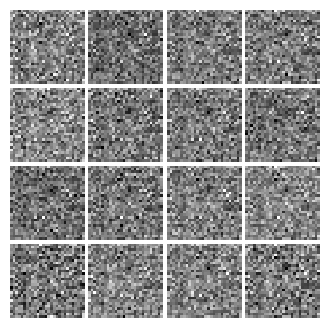


Iter: 250, D: 0.1634, G:0.3074


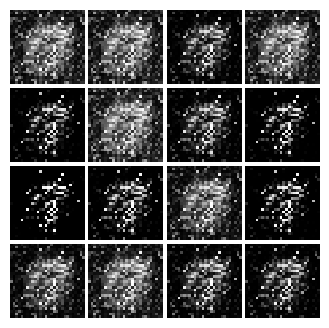


EPOCH:  2
Iter: 500, D: 0.2036, G:0.4363


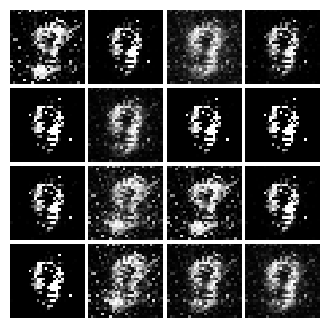


Iter: 750, D: 0.1911, G:0.2635


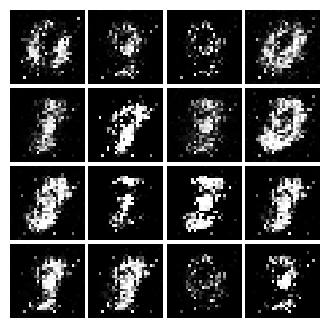


EPOCH:  3
Iter: 1000, D: 0.1482, G:0.5304


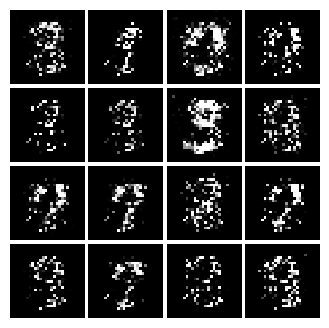


Iter: 1250, D: 0.1839, G:0.177


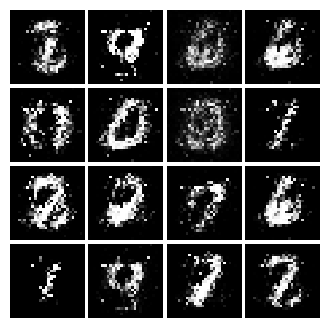


EPOCH:  4
Iter: 1500, D: 0.2488, G:0.2264


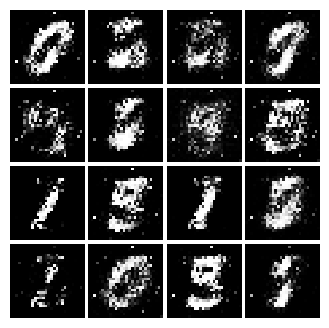


Iter: 1750, D: 0.2716, G:0.1866


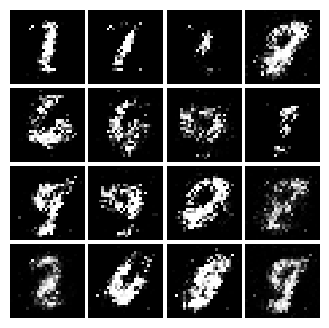


EPOCH:  5
Iter: 2000, D: 0.1876, G:0.1555


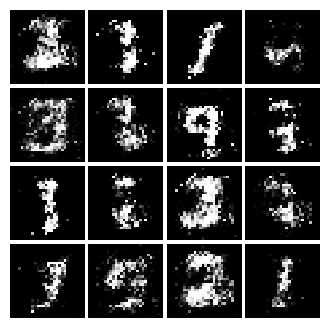


Iter: 2250, D: 0.2292, G:0.09895


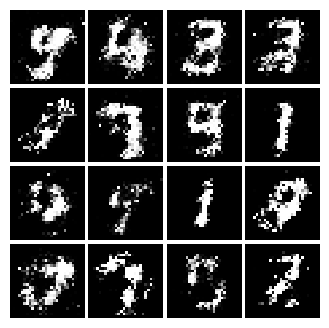


EPOCH:  6
Iter: 2500, D: 0.1949, G:0.2687


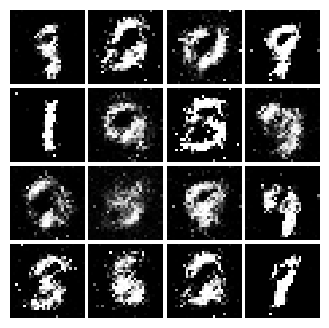


Iter: 2750, D: 0.2398, G:0.1678


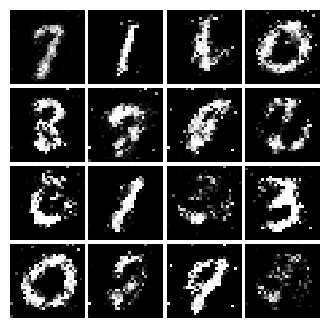


EPOCH:  7
Iter: 3000, D: 0.2224, G:0.1479


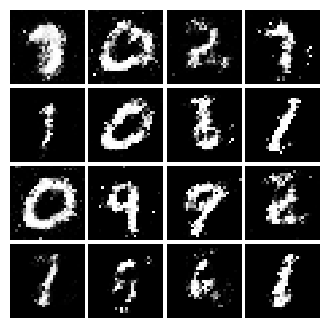


Iter: 3250, D: 0.2093, G:0.1993


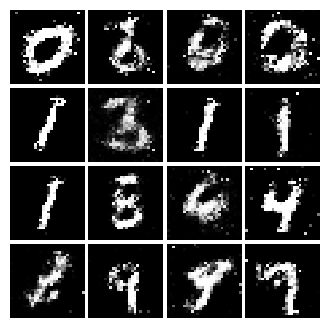


EPOCH:  8
Iter: 3500, D: 0.2324, G:0.1648


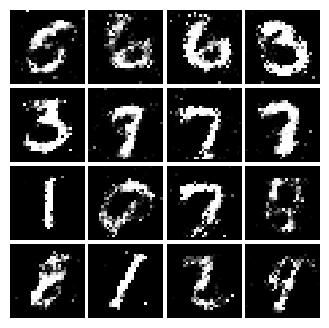


EPOCH:  9
Iter: 3750, D: 0.2121, G:0.1783


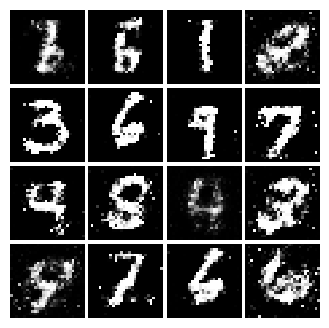


Iter: 4000, D: 0.2289, G:0.1571


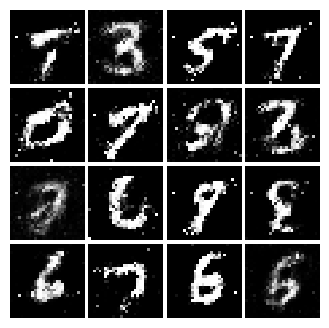


EPOCH:  10
Iter: 4250, D: 0.208, G:0.1862


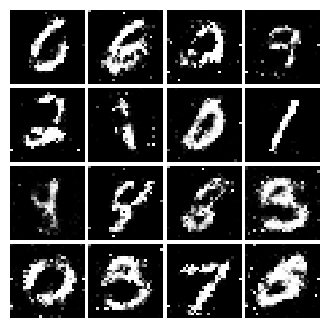


Iter: 4500, D: 0.2181, G:0.1812


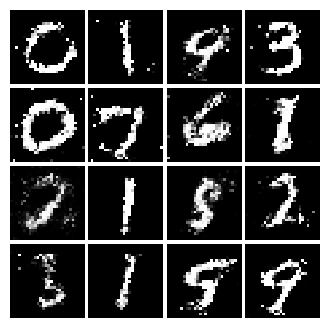

In [34]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)